In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as torchv
import numpy as np
import mymodels
import mycoco
import torchvision.transforms as transforms
import torch.utils.data as data
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import os
import pdb

from random import randint
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
print("Torch Version: {}".format(torch.__version__))
print("Cuda Available: {} \t device Count: {}".format(torch.cuda.is_available(), torch.cuda.device_count()))

Torch Version: 1.0.1.post2
Cuda Available: True 	 device Count: 1


In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
cuda = torch.cuda.is_available()

In [4]:
datasets

<module 'torchvision.datasets' from '/nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torchvision/datasets/__init__.py'>

In [5]:
mycoco.CocoDetection?

Init signature:
mycoco.CocoDetection(
    root,
    annFile,
    transform=None,
    target_transform=None,
    categories=None,
    batch_size=32,
)
Docstring:     
`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

Args:
    root (string): Root directory where images are downloaded to.
    annFile (string): Path to json annotation file.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.ToTensor``
    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
File:           /nfs/eecs-fserv/share/linzhe/CS535Proj/TestExamples/AutoEncoder/mycoco.py
Type:           type
Subclasses:     


In [6]:
def create_dataset(name='train', batch_size=32):
    dataDir='/scratch/cluster-share/linzhe/cocoDataset/'
    dataType='%s2017'%name
    annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
    root = '%s%s'%(dataDir, dataType)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    trans = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor()])
    target_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                           transforms.ToTensor()
                                           ]) # normalize to be in [-1, 1]
    coco = mycoco.CocoDetection(root, annFile, transform=trans, target_transform=target_transform, categories=['pizza'])
    cocoloader = data.DataLoader(coco, batch_size, num_workers=4, shuffle=True)
    
    return cocoloader, coco

In [7]:
cocoloader, cocoDataset = create_dataset(name='train', batch_size=BATCH_SIZE)

loading annotations into memory...
Done (t=20.88s)
creating index...
index created!


In [8]:
# check that there exist 10 different classes
np.unique(cocoDataset.categories)

array(['pizza'], dtype='<U5')

torch.Size([64, 3, 224, 224])
(224, 224, 3)


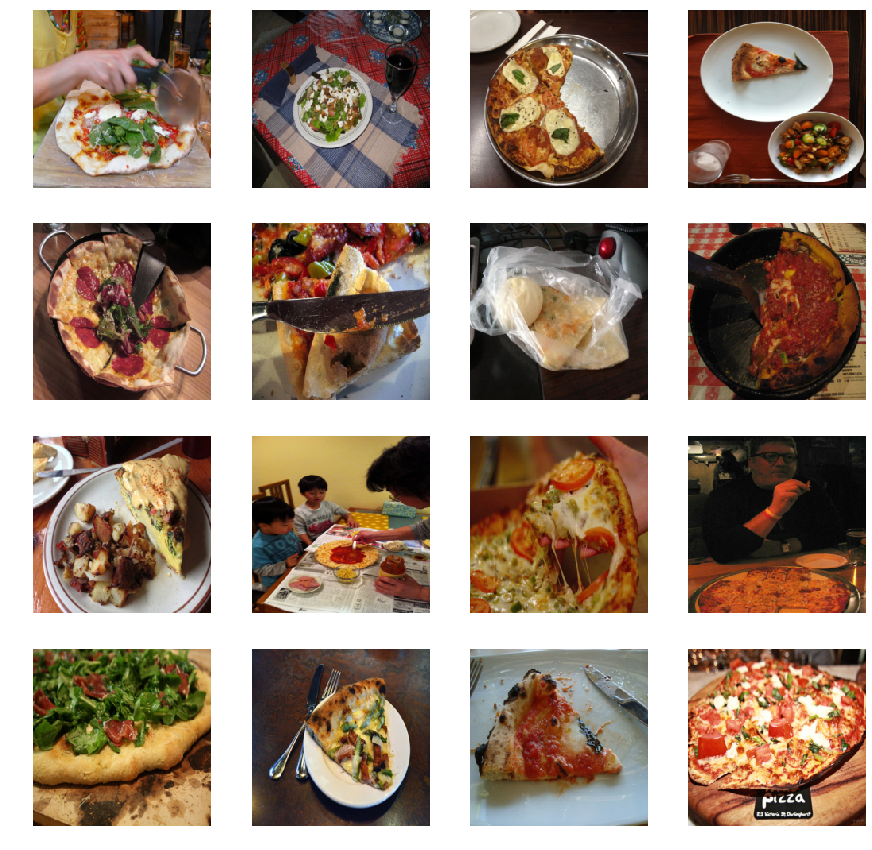

In [9]:
for im, mask in cocoloader:
    print(im.shape)
    print(np.swapaxes(np.swapaxes(im[0].numpy(),0,1),1,2).shape)
    break
    


f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break

27447.12
11571.006
9622.628
4556.4585
18775.807
7163.8823
16695.13
10888.261
24378.508
19664.818
4805.0273
25488.969
21126.244
6673.2905
24602.738
5668.2627


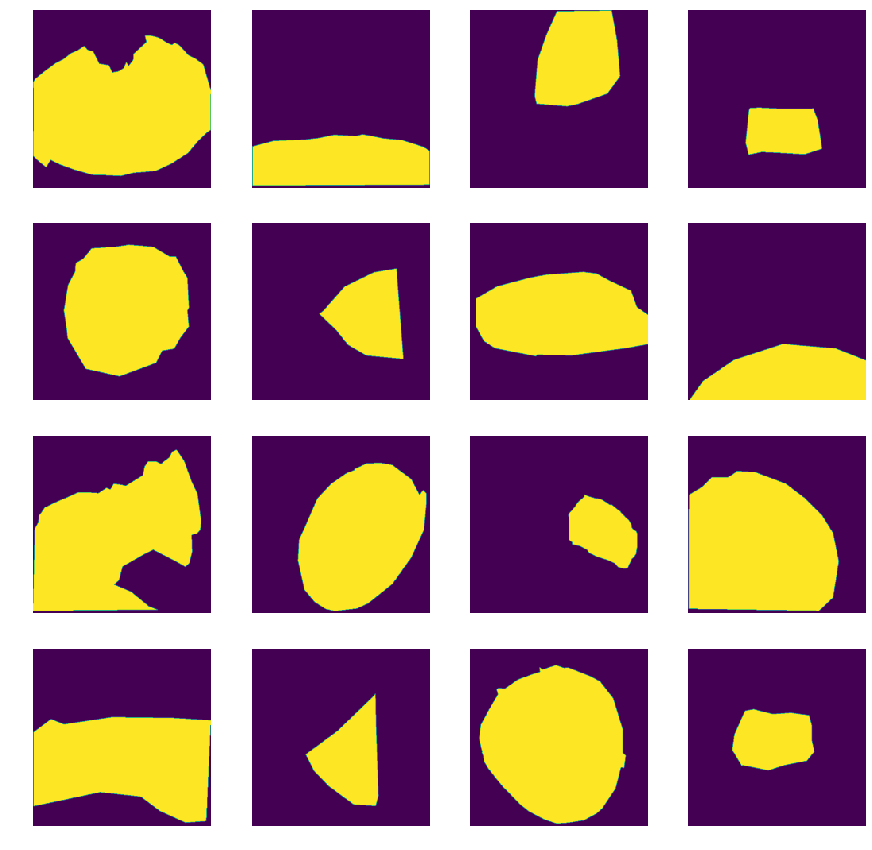

In [10]:

f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
    
    for image in mask:
        print(np.sum(image.numpy()[0]))
#         print(image.numpy()[0])
#         print(image.numpy()[0].shape)
        axarr[i, j].imshow(image.numpy()[0])
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break
    

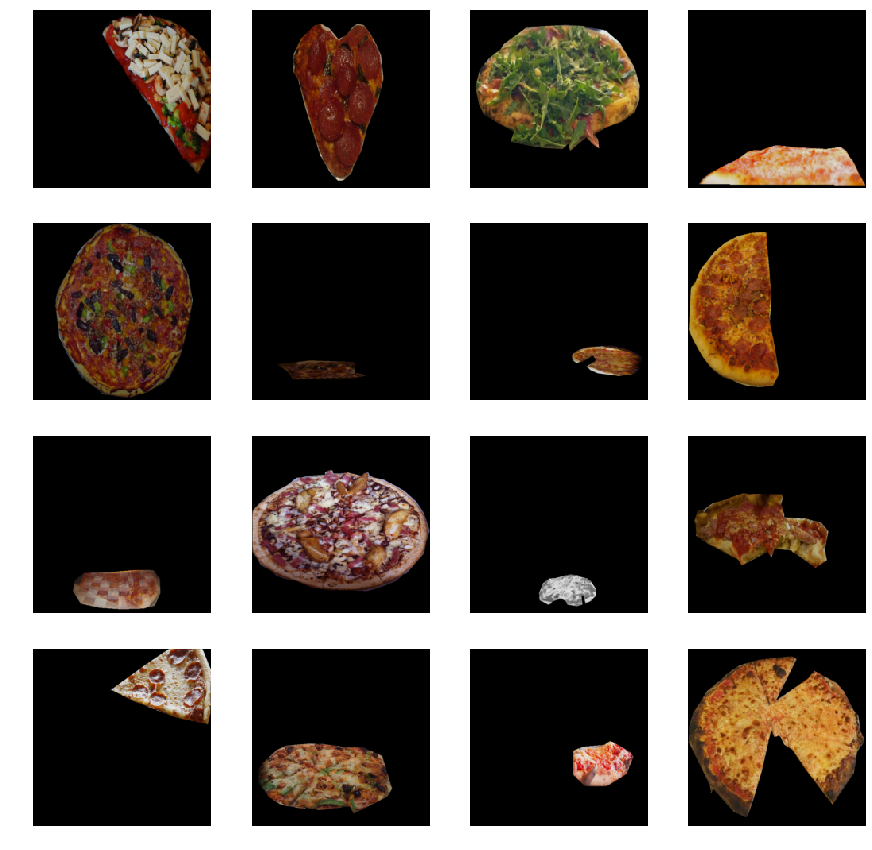

In [11]:
f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
    im = np.multiply(im,mask)
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break

In [12]:

data_loader = cocoloader
# pin_memory if you're on GPU

In [13]:
from torch import nn

In [14]:
n_batches = int(np.ceil(len(cocoDataset)/ BATCH_SIZE)) # 60000 / 100

In [15]:
n_batches

34

In [16]:
class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()

        self.image_dim = IMAGE_SIZE # a 28x28 image corresponds to 4 on the FC layer, a 64x64 image corresponds to 13
                            # can calculate this using output_after_conv() in utils.py
        self.latent_dim = 100
        self.noise_scale = 0
        self.batch_size = 50
        
        self.del1_size = int(IMAGE_SIZE / 4)
        self.del2_size = int(IMAGE_SIZE / 2)

        self.encoder_l1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.encoder_l2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.encoder_l3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU())
        self.encoder_l4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU())
        self.fc1 = nn.Linear(32*self.del1_size*self.del1_size, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim, 32*self.del1_size*self.del1_size)
        self.decoder_l1 = nn.Sequential(
            nn.ConvTranspose2d(33, 32, kernel_size=3, stride=2, padding=1, output_padding = 1),
            nn.ReLU())
        #self.m1 = nn.MaxPool2d(3, stride=2)
        self.decoder_l2 = nn.Sequential(
            nn.ConvTranspose2d(33, 32, kernel_size=3, stride=2, padding=1, output_padding = 1),
            nn.ReLU())
        #self.m1 = nn.MaxPool2d(3, stride=2)
        self.decoder_l3 = nn.Sequential(
            nn.ConvTranspose2d(33, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        #self.m1 = nn.MaxPool2d(3, stride=2)
        self.decoder_l4 = nn.Sequential(
            nn.ConvTranspose2d(17, 3, kernel_size=3, stride=1, padding=1))
	    #nn.Sigmoid())
        
        
    def forward(self, x, mask):
        n = x.size()[0]
        if cuda:
            noise =  Variable(self.noise_scale*torch.randn(n, 1, self.image_dim, self.image_dim)).cuda()
        else:
            noise = Variable(self.noise_scale * torch.randn(n, 1, self.image_dim, self.image_dim))

        #x = torch.add(x, noise)
        #print("****")
        #print(x.shape)
        x = self.encoder_l1(x)
        #print(x.shape)
        x = self.encoder_l2(x)
        #print(x.shape)
        x = self.encoder_l3(x)
        #print(x.shape)
        z = self.encoder_l4(x)
        #print(x.shape)
        #z = self.encoder(x)
        z = z.view(-1, 32*self.del1_size*self.del1_size)
        z = self.fc1(z)
        x_hat = self.fc2(z)
        x_hat = x_hat.view(-1, 32, self.del1_size, self.del1_size)
        
        #print(x_hat.shape)
        
        m1 = nn.MaxPool2d(4, stride = 4)
        mask_l1 = m1(mask)
        #print(mask_l1.shape)
        #print(type(x_hat), type(mask_l1))
        x_hat = torch.cat((x_hat, mask_l1), dim = 1)
        x_hat = self.decoder_l1(x_hat)
        #print(x_hat.shape)
        m2 = nn.MaxPool2d(2, stride = 2)
        mask_l2 = m2(mask)
        x_hat = torch.cat((x_hat, mask_l2), dim = 1)
        #print(mask_l2.shape)
        x_hat = self.decoder_l2(x_hat)
        x_hat = torch.cat((x_hat, mask), dim = 1)
        #print(x_hat.shape)
        x_hat = self.decoder_l3(x_hat)
        x_hat = torch.cat((x_hat, mask), dim = 1)
        #print(x_hat.shape)
        x_hat = self.decoder_l4(x_hat)

        return z, x_hat

    def encode(self, x):
        #x = x.unsqueeze(0)
        z, x_hat = self.forward(x)

        return z

In [17]:
n_batches


34

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


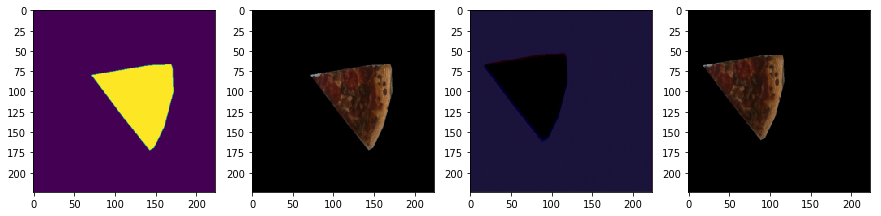

Epoch [0/5000], Step[34/34], d_loss: 0.0084, g_loss: 0.0084, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1/5000], Step[34/34], d_loss: 0.0139, g_loss: 0.0139, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2/5000], Step[34/34], d_loss: 0.0080, g_loss: 0.0080, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3/5000], Step[34/34], d_loss: 0.0071, g_loss: 0.0071, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4/5000], Step[34/34], d_loss: 0.0093, g_loss: 0.0093, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [5/5000], Step[34/34], d_loss: 0.0108, g_loss: 0.0108, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [6/5000], Step[34/34], d_loss: 0.0077, g_loss: 0.0077, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [7/5000], Step[34/34], d_loss: 0.0074, g_loss: 0.0074, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [8/5000], Step[34/34], d_loss: 0.0117, g_loss: 0.0117, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [9/5000], Step[34/34], d_loss: 0.0077, g_loss: 0.0077, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [10/5000], Step[34/34], 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


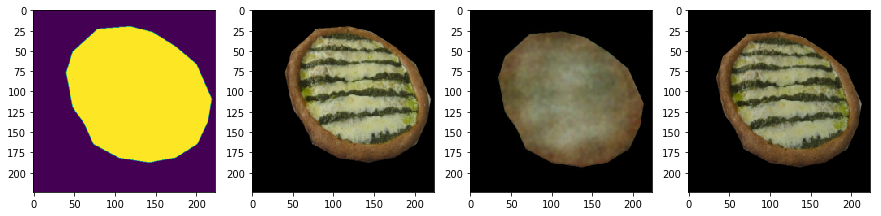

Epoch [100/5000], Step[34/34], d_loss: 0.0031, g_loss: 0.0031, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [101/5000], Step[34/34], d_loss: 0.0048, g_loss: 0.0048, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [102/5000], Step[34/34], d_loss: 0.0037, g_loss: 0.0037, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [103/5000], Step[34/34], d_loss: 0.0017, g_loss: 0.0017, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [104/5000], Step[34/34], d_loss: 0.0040, g_loss: 0.0040, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [105/5000], Step[34/34], d_loss: 0.0056, g_loss: 0.0056, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [106/5000], Step[34/34], d_loss: 0.0048, g_loss: 0.0048, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [107/5000], Step[34/34], d_loss: 0.0055, g_loss: 0.0055, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [108/5000], Step[34/34], d_loss: 0.0050, g_loss: 0.0050, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [109/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [110

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


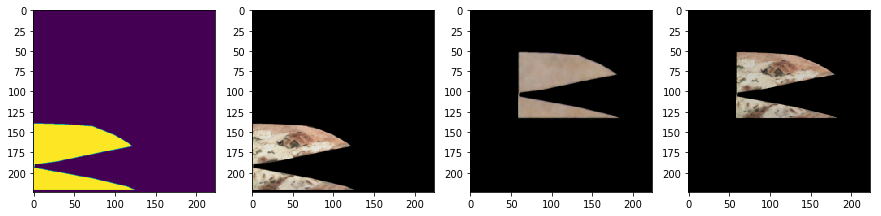

Epoch [200/5000], Step[34/34], d_loss: 0.0065, g_loss: 0.0065, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [201/5000], Step[34/34], d_loss: 0.0042, g_loss: 0.0042, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [202/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [203/5000], Step[34/34], d_loss: 0.0031, g_loss: 0.0031, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [204/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [205/5000], Step[34/34], d_loss: 0.0044, g_loss: 0.0044, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [206/5000], Step[34/34], d_loss: 0.0044, g_loss: 0.0044, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [207/5000], Step[34/34], d_loss: 0.0044, g_loss: 0.0044, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [208/5000], Step[34/34], d_loss: 0.0032, g_loss: 0.0032, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [209/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [210

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


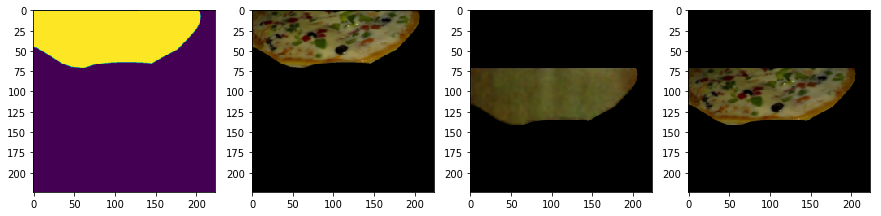

Epoch [300/5000], Step[34/34], d_loss: 0.0046, g_loss: 0.0046, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [301/5000], Step[34/34], d_loss: 0.0047, g_loss: 0.0047, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [302/5000], Step[34/34], d_loss: 0.0027, g_loss: 0.0027, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [303/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [304/5000], Step[34/34], d_loss: 0.0032, g_loss: 0.0032, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [305/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [306/5000], Step[34/34], d_loss: 0.0027, g_loss: 0.0027, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [307/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [308/5000], Step[34/34], d_loss: 0.0026, g_loss: 0.0026, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [309/5000], Step[34/34], d_loss: 0.0041, g_loss: 0.0041, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [310

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


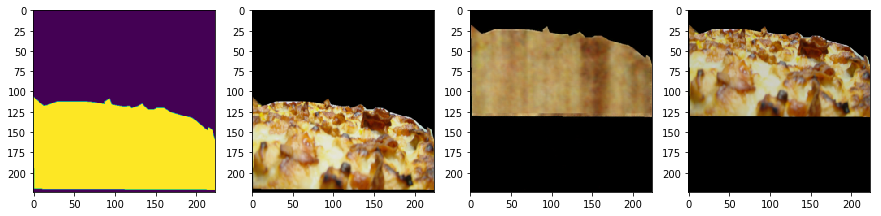

Epoch [400/5000], Step[34/34], d_loss: 0.0030, g_loss: 0.0030, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [401/5000], Step[34/34], d_loss: 0.0046, g_loss: 0.0046, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [402/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [403/5000], Step[34/34], d_loss: 0.0028, g_loss: 0.0028, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [404/5000], Step[34/34], d_loss: 0.0042, g_loss: 0.0042, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [405/5000], Step[34/34], d_loss: 0.0033, g_loss: 0.0033, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [406/5000], Step[34/34], d_loss: 0.0070, g_loss: 0.0070, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [407/5000], Step[34/34], d_loss: 0.0031, g_loss: 0.0031, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [408/5000], Step[34/34], d_loss: 0.0042, g_loss: 0.0042, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [409/5000], Step[34/34], d_loss: 0.0044, g_loss: 0.0044, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [410

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


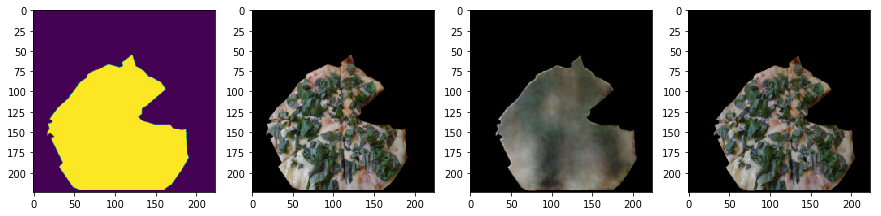

Epoch [500/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [501/5000], Step[34/34], d_loss: 0.0062, g_loss: 0.0062, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [502/5000], Step[34/34], d_loss: 0.0053, g_loss: 0.0053, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [503/5000], Step[34/34], d_loss: 0.0048, g_loss: 0.0048, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [504/5000], Step[34/34], d_loss: 0.0033, g_loss: 0.0033, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [505/5000], Step[34/34], d_loss: 0.0037, g_loss: 0.0037, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [506/5000], Step[34/34], d_loss: 0.0028, g_loss: 0.0028, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [507/5000], Step[34/34], d_loss: 0.0044, g_loss: 0.0044, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [508/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [509/5000], Step[34/34], d_loss: 0.0026, g_loss: 0.0026, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [510

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


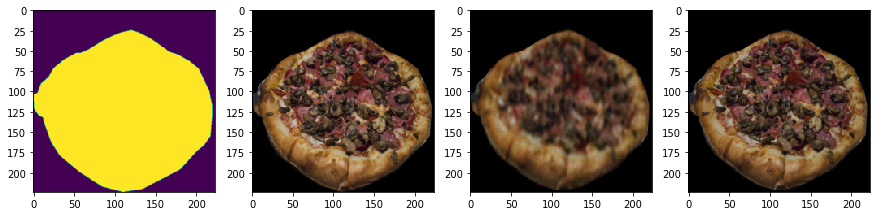

Epoch [600/5000], Step[34/34], d_loss: 0.0045, g_loss: 0.0045, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [601/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [602/5000], Step[34/34], d_loss: 0.0046, g_loss: 0.0046, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [603/5000], Step[34/34], d_loss: 0.0043, g_loss: 0.0043, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [604/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [605/5000], Step[34/34], d_loss: 0.0040, g_loss: 0.0040, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [606/5000], Step[34/34], d_loss: 0.0052, g_loss: 0.0052, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [607/5000], Step[34/34], d_loss: 0.0031, g_loss: 0.0031, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [608/5000], Step[34/34], d_loss: 0.0031, g_loss: 0.0031, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [609/5000], Step[34/34], d_loss: 0.0030, g_loss: 0.0030, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [610

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


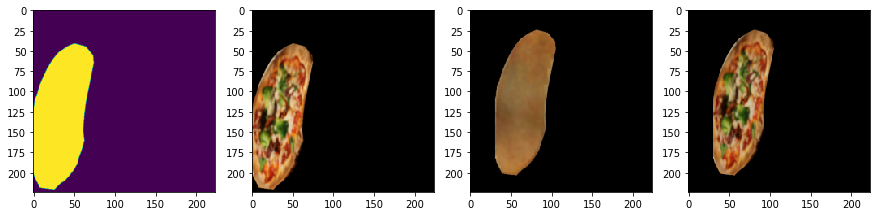

Epoch [700/5000], Step[34/34], d_loss: 0.0028, g_loss: 0.0028, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [701/5000], Step[34/34], d_loss: 0.0022, g_loss: 0.0022, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [702/5000], Step[34/34], d_loss: 0.0032, g_loss: 0.0032, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [703/5000], Step[34/34], d_loss: 0.0040, g_loss: 0.0040, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [704/5000], Step[34/34], d_loss: 0.0050, g_loss: 0.0050, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [705/5000], Step[34/34], d_loss: 0.0014, g_loss: 0.0014, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [706/5000], Step[34/34], d_loss: 0.0037, g_loss: 0.0037, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [707/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [708/5000], Step[34/34], d_loss: 0.0020, g_loss: 0.0020, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [709/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [710

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


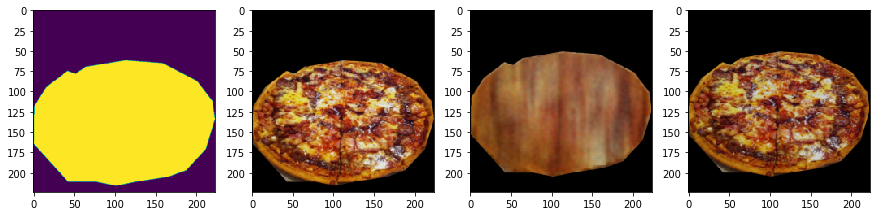

Epoch [800/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [801/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [802/5000], Step[34/34], d_loss: 0.0037, g_loss: 0.0037, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [803/5000], Step[34/34], d_loss: 0.0037, g_loss: 0.0037, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [804/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [805/5000], Step[34/34], d_loss: 0.0049, g_loss: 0.0049, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [806/5000], Step[34/34], d_loss: 0.0042, g_loss: 0.0042, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [807/5000], Step[34/34], d_loss: 0.0043, g_loss: 0.0043, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [808/5000], Step[34/34], d_loss: 0.0027, g_loss: 0.0027, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [809/5000], Step[34/34], d_loss: 0.0050, g_loss: 0.0050, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [810

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


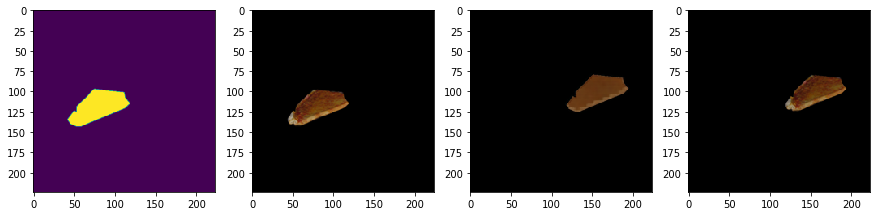

Epoch [900/5000], Step[34/34], d_loss: 0.0053, g_loss: 0.0053, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [901/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [902/5000], Step[34/34], d_loss: 0.0051, g_loss: 0.0051, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [903/5000], Step[34/34], d_loss: 0.0031, g_loss: 0.0031, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [904/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [905/5000], Step[34/34], d_loss: 0.0033, g_loss: 0.0033, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [906/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [907/5000], Step[34/34], d_loss: 0.0021, g_loss: 0.0021, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [908/5000], Step[34/34], d_loss: 0.0044, g_loss: 0.0044, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [909/5000], Step[34/34], d_loss: 0.0024, g_loss: 0.0024, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [910

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


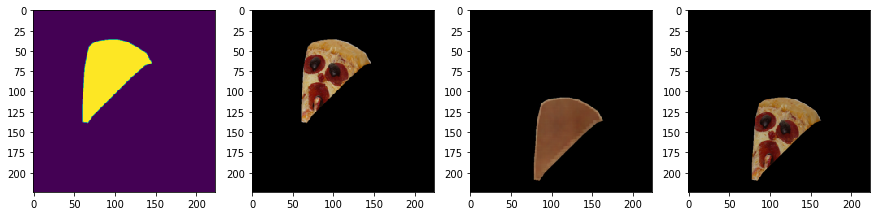

Epoch [1000/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1001/5000], Step[34/34], d_loss: 0.0033, g_loss: 0.0033, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1002/5000], Step[34/34], d_loss: 0.0050, g_loss: 0.0050, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1003/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1004/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1005/5000], Step[34/34], d_loss: 0.0032, g_loss: 0.0032, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1006/5000], Step[34/34], d_loss: 0.0065, g_loss: 0.0065, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1007/5000], Step[34/34], d_loss: 0.0023, g_loss: 0.0023, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1008/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1009/5000], Step[34/34], d_loss: 0.0027, g_loss: 0.0027, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


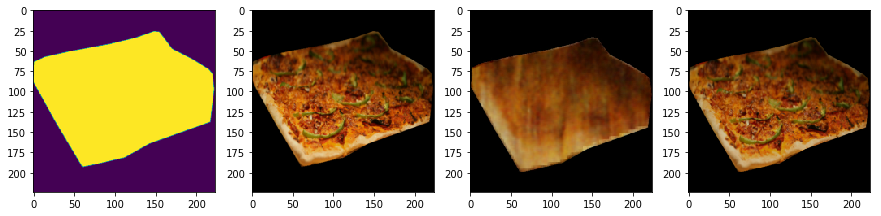

Epoch [1100/5000], Step[34/34], d_loss: 0.0029, g_loss: 0.0029, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1101/5000], Step[34/34], d_loss: 0.0028, g_loss: 0.0028, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1102/5000], Step[34/34], d_loss: 0.0019, g_loss: 0.0019, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1103/5000], Step[34/34], d_loss: 0.0024, g_loss: 0.0024, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1104/5000], Step[34/34], d_loss: 0.0046, g_loss: 0.0046, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1105/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1106/5000], Step[34/34], d_loss: 0.0041, g_loss: 0.0041, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1107/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1108/5000], Step[34/34], d_loss: 0.0041, g_loss: 0.0041, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1109/5000], Step[34/34], d_loss: 0.0026, g_loss: 0.0026, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


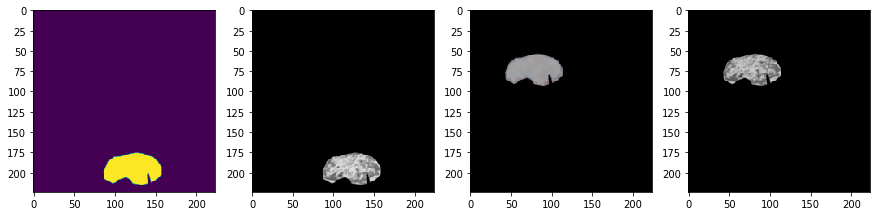

Epoch [1200/5000], Step[34/34], d_loss: 0.0026, g_loss: 0.0026, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1201/5000], Step[34/34], d_loss: 0.0023, g_loss: 0.0023, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1202/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1203/5000], Step[34/34], d_loss: 0.0056, g_loss: 0.0056, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1204/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1205/5000], Step[34/34], d_loss: 0.0033, g_loss: 0.0033, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1206/5000], Step[34/34], d_loss: 0.0055, g_loss: 0.0055, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1207/5000], Step[34/34], d_loss: 0.0032, g_loss: 0.0032, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1208/5000], Step[34/34], d_loss: 0.0047, g_loss: 0.0047, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1209/5000], Step[34/34], d_loss: 0.0028, g_loss: 0.0028, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


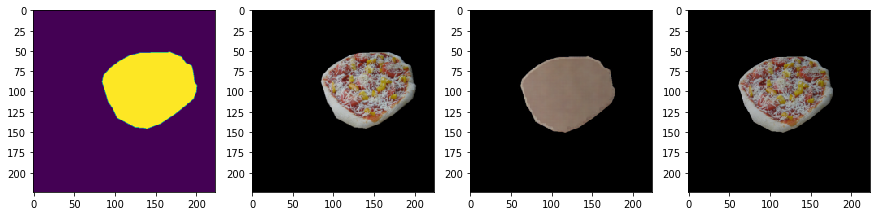

Epoch [1300/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1301/5000], Step[34/34], d_loss: 0.0031, g_loss: 0.0031, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1302/5000], Step[34/34], d_loss: 0.0024, g_loss: 0.0024, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1303/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1304/5000], Step[34/34], d_loss: 0.0016, g_loss: 0.0016, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1305/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1306/5000], Step[34/34], d_loss: 0.0042, g_loss: 0.0042, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1307/5000], Step[34/34], d_loss: 0.0021, g_loss: 0.0021, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1308/5000], Step[34/34], d_loss: 0.0028, g_loss: 0.0028, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1309/5000], Step[34/34], d_loss: 0.0046, g_loss: 0.0046, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


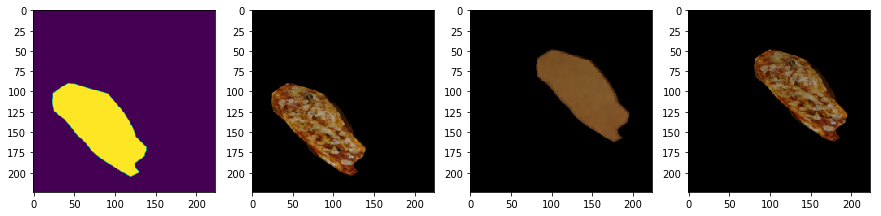

Epoch [1400/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1401/5000], Step[34/34], d_loss: 0.0053, g_loss: 0.0053, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1402/5000], Step[34/34], d_loss: 0.0049, g_loss: 0.0049, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1403/5000], Step[34/34], d_loss: 0.0060, g_loss: 0.0060, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1404/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1405/5000], Step[34/34], d_loss: 0.0029, g_loss: 0.0029, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1406/5000], Step[34/34], d_loss: 0.0040, g_loss: 0.0040, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1407/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1408/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1409/5000], Step[34/34], d_loss: 0.0030, g_loss: 0.0030, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


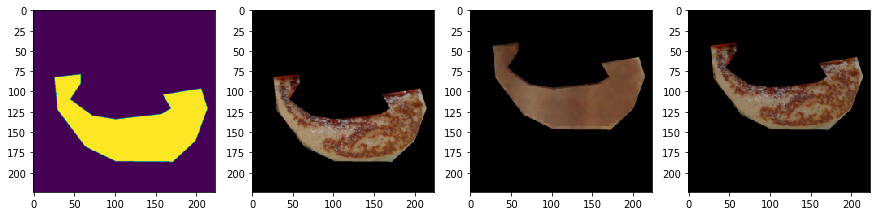

Epoch [1500/5000], Step[34/34], d_loss: 0.0015, g_loss: 0.0015, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1501/5000], Step[34/34], d_loss: 0.0049, g_loss: 0.0049, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1502/5000], Step[34/34], d_loss: 0.0043, g_loss: 0.0043, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1503/5000], Step[34/34], d_loss: 0.0043, g_loss: 0.0043, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1504/5000], Step[34/34], d_loss: 0.0020, g_loss: 0.0020, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1505/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1506/5000], Step[34/34], d_loss: 0.0027, g_loss: 0.0027, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1507/5000], Step[34/34], d_loss: 0.0021, g_loss: 0.0021, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1508/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1509/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


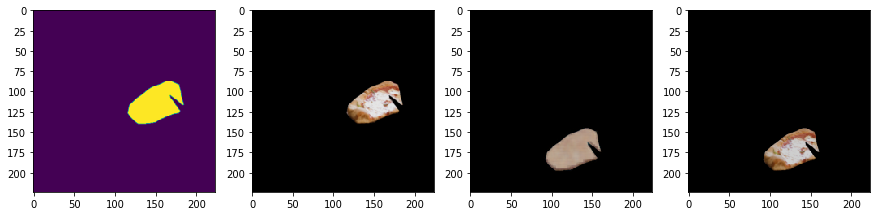

Epoch [1600/5000], Step[34/34], d_loss: 0.0023, g_loss: 0.0023, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1601/5000], Step[34/34], d_loss: 0.0037, g_loss: 0.0037, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1602/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1603/5000], Step[34/34], d_loss: 0.0029, g_loss: 0.0029, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1604/5000], Step[34/34], d_loss: 0.0028, g_loss: 0.0028, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1605/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1606/5000], Step[34/34], d_loss: 0.0052, g_loss: 0.0052, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1607/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1608/5000], Step[34/34], d_loss: 0.0048, g_loss: 0.0048, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1609/5000], Step[34/34], d_loss: 0.0030, g_loss: 0.0030, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


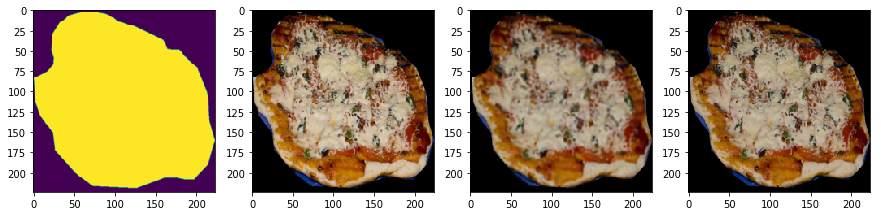

Epoch [1700/5000], Step[34/34], d_loss: 0.0022, g_loss: 0.0022, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1701/5000], Step[34/34], d_loss: 0.0020, g_loss: 0.0020, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1702/5000], Step[34/34], d_loss: 0.0057, g_loss: 0.0057, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1703/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1704/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1705/5000], Step[34/34], d_loss: 0.0050, g_loss: 0.0050, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1706/5000], Step[34/34], d_loss: 0.0032, g_loss: 0.0032, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1707/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1708/5000], Step[34/34], d_loss: 0.0048, g_loss: 0.0048, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1709/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


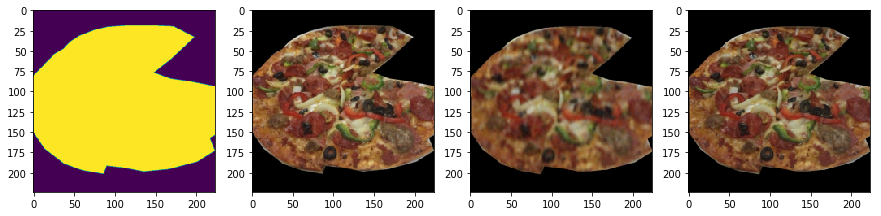

Epoch [1800/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1801/5000], Step[34/34], d_loss: 0.0021, g_loss: 0.0021, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1802/5000], Step[34/34], d_loss: 0.0020, g_loss: 0.0020, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1803/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1804/5000], Step[34/34], d_loss: 0.0024, g_loss: 0.0024, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1805/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1806/5000], Step[34/34], d_loss: 0.0045, g_loss: 0.0045, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1807/5000], Step[34/34], d_loss: 0.0014, g_loss: 0.0014, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1808/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1809/5000], Step[34/34], d_loss: 0.0029, g_loss: 0.0029, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


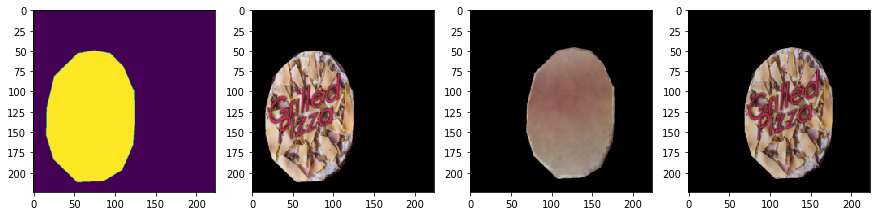

Epoch [1900/5000], Step[34/34], d_loss: 0.0031, g_loss: 0.0031, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1901/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1902/5000], Step[34/34], d_loss: 0.0047, g_loss: 0.0047, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1903/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1904/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1905/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1906/5000], Step[34/34], d_loss: 0.0023, g_loss: 0.0023, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1907/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1908/5000], Step[34/34], d_loss: 0.0020, g_loss: 0.0020, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1909/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


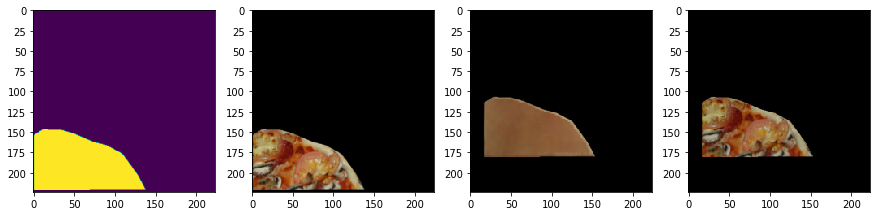

Epoch [2000/5000], Step[34/34], d_loss: 0.0030, g_loss: 0.0030, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2001/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2002/5000], Step[34/34], d_loss: 0.0016, g_loss: 0.0016, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2003/5000], Step[34/34], d_loss: 0.0027, g_loss: 0.0027, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2004/5000], Step[34/34], d_loss: 0.0046, g_loss: 0.0046, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2005/5000], Step[34/34], d_loss: 0.0040, g_loss: 0.0040, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2006/5000], Step[34/34], d_loss: 0.0032, g_loss: 0.0032, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2007/5000], Step[34/34], d_loss: 0.0053, g_loss: 0.0053, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2008/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2009/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


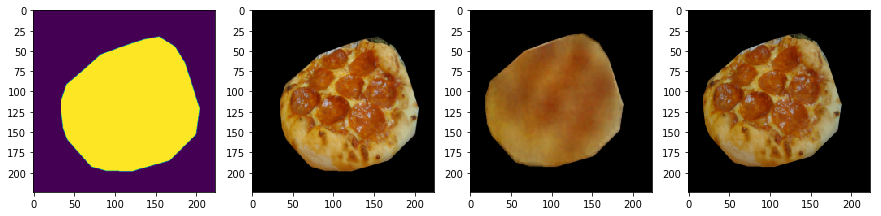

Epoch [2100/5000], Step[34/34], d_loss: 0.0028, g_loss: 0.0028, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2101/5000], Step[34/34], d_loss: 0.0043, g_loss: 0.0043, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2102/5000], Step[34/34], d_loss: 0.0027, g_loss: 0.0027, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2103/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2104/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2105/5000], Step[34/34], d_loss: 0.0041, g_loss: 0.0041, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2106/5000], Step[34/34], d_loss: 0.0041, g_loss: 0.0041, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2107/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2108/5000], Step[34/34], d_loss: 0.0024, g_loss: 0.0024, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2109/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


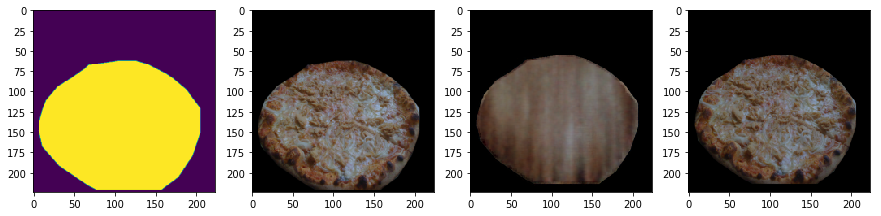

Epoch [2200/5000], Step[34/34], d_loss: 0.0051, g_loss: 0.0051, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2201/5000], Step[34/34], d_loss: 0.0024, g_loss: 0.0024, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2202/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2203/5000], Step[34/34], d_loss: 0.0033, g_loss: 0.0033, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2204/5000], Step[34/34], d_loss: 0.0041, g_loss: 0.0041, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2205/5000], Step[34/34], d_loss: 0.0037, g_loss: 0.0037, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2206/5000], Step[34/34], d_loss: 0.0041, g_loss: 0.0041, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2207/5000], Step[34/34], d_loss: 0.0033, g_loss: 0.0033, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2208/5000], Step[34/34], d_loss: 0.0030, g_loss: 0.0030, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2209/5000], Step[34/34], d_loss: 0.0040, g_loss: 0.0040, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


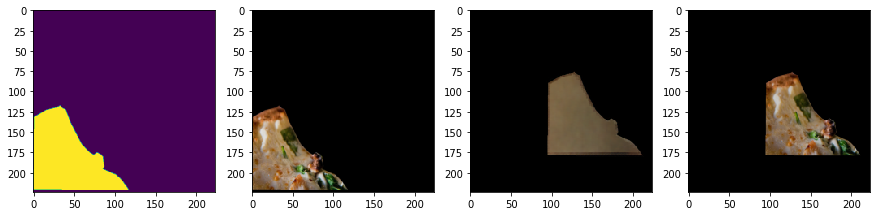

Epoch [2300/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2301/5000], Step[34/34], d_loss: 0.0037, g_loss: 0.0037, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2302/5000], Step[34/34], d_loss: 0.0029, g_loss: 0.0029, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2303/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2304/5000], Step[34/34], d_loss: 0.0033, g_loss: 0.0033, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2305/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2306/5000], Step[34/34], d_loss: 0.0037, g_loss: 0.0037, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2307/5000], Step[34/34], d_loss: 0.0026, g_loss: 0.0026, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2308/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2309/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


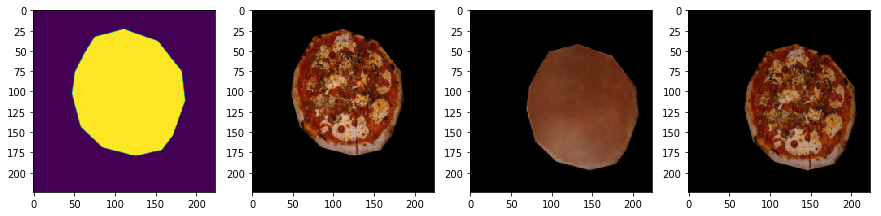

Epoch [2400/5000], Step[34/34], d_loss: 0.0041, g_loss: 0.0041, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2401/5000], Step[34/34], d_loss: 0.0028, g_loss: 0.0028, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2402/5000], Step[34/34], d_loss: 0.0031, g_loss: 0.0031, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2403/5000], Step[34/34], d_loss: 0.0030, g_loss: 0.0030, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2404/5000], Step[34/34], d_loss: 0.0027, g_loss: 0.0027, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2405/5000], Step[34/34], d_loss: 0.0032, g_loss: 0.0032, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2406/5000], Step[34/34], d_loss: 0.0032, g_loss: 0.0032, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2407/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2408/5000], Step[34/34], d_loss: 0.0041, g_loss: 0.0041, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2409/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


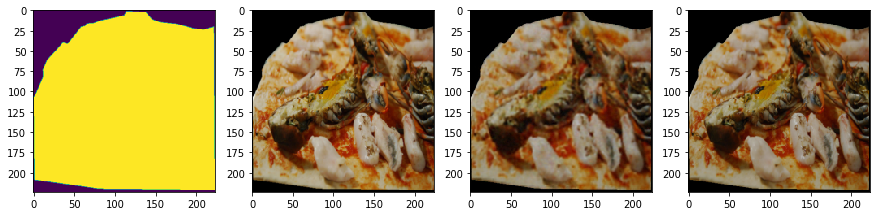

Epoch [2500/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2501/5000], Step[34/34], d_loss: 0.0054, g_loss: 0.0054, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2502/5000], Step[34/34], d_loss: 0.0033, g_loss: 0.0033, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2503/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2504/5000], Step[34/34], d_loss: 0.0022, g_loss: 0.0022, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2505/5000], Step[34/34], d_loss: 0.0023, g_loss: 0.0023, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2506/5000], Step[34/34], d_loss: 0.0026, g_loss: 0.0026, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2507/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2508/5000], Step[34/34], d_loss: 0.0045, g_loss: 0.0045, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2509/5000], Step[34/34], d_loss: 0.0019, g_loss: 0.0019, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


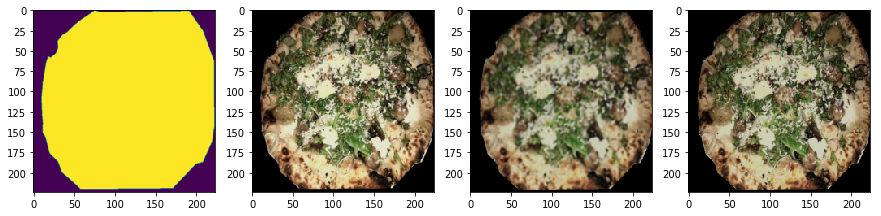

Epoch [2600/5000], Step[34/34], d_loss: 0.0037, g_loss: 0.0037, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2601/5000], Step[34/34], d_loss: 0.0032, g_loss: 0.0032, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2602/5000], Step[34/34], d_loss: 0.0027, g_loss: 0.0027, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2603/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2604/5000], Step[34/34], d_loss: 0.0040, g_loss: 0.0040, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2605/5000], Step[34/34], d_loss: 0.0041, g_loss: 0.0041, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2606/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2607/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2608/5000], Step[34/34], d_loss: 0.0016, g_loss: 0.0016, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2609/5000], Step[34/34], d_loss: 0.0025, g_loss: 0.0025, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


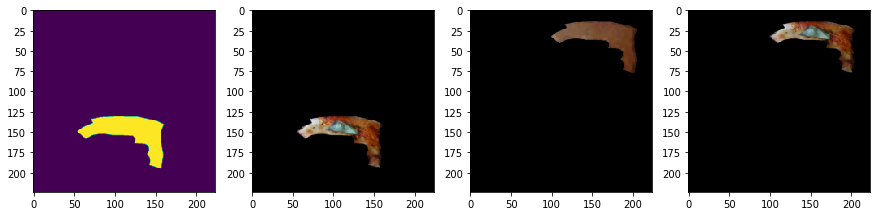

Epoch [2700/5000], Step[34/34], d_loss: 0.0029, g_loss: 0.0029, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2701/5000], Step[34/34], d_loss: 0.0033, g_loss: 0.0033, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2702/5000], Step[34/34], d_loss: 0.0022, g_loss: 0.0022, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2703/5000], Step[34/34], d_loss: 0.0058, g_loss: 0.0058, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2704/5000], Step[34/34], d_loss: 0.0020, g_loss: 0.0020, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2705/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2706/5000], Step[34/34], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2707/5000], Step[34/34], d_loss: 0.0038, g_loss: 0.0038, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2708/5000], Step[34/34], d_loss: 0.0018, g_loss: 0.0018, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2709/5000], Step[34/34], d_loss: 0.0039, g_loss: 0.0039, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


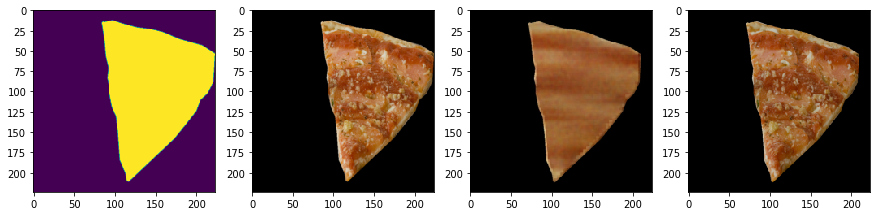

Epoch [2800/5000], Step[34/34], d_loss: 0.0024, g_loss: 0.0024, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2801/5000], Step[34/34], d_loss: 0.0024, g_loss: 0.0024, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2802/5000], Step[34/34], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2803/5000], Step[34/34], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2804/5000], Step[34/34], d_loss: 0.0037, g_loss: 0.0037, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2805/5000], Step[34/34], d_loss: 0.0028, g_loss: 0.0028, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2806/5000], Step[34/34], d_loss: 0.0030, g_loss: 0.0030, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2807/5000], Step[34/34], d_loss: 0.0031, g_loss: 0.0031, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2808/5000], Step[34/34], d_loss: 0.0019, g_loss: 0.0019, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2809/5000], Step[34/34], d_loss: 0.0045, g_loss: 0.0045, Mean D(x): 0.00, Mean D(G(z)): 0.00


In [ ]:
dae = DAE()
if cuda:
    dae.cuda()
num_epochs = 5000
dae.batch_size = BATCH_SIZE
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dae.parameters(), lr=learning_rate)
f_result = open('./weights_mask/train_loss.txt', 'w')
f_result.close()
for epoch in range(num_epochs + 1):
    f_result = open('./weights_mask/train_loss.txt', 'a')
    total_loss = 0
    epoch_start = True # quick hack
    
    for I, (images, masks) in enumerate(cocoloader):
        target_imgs = np.zeros_like(images)
        target_masks = np.zeros_like(masks)
        
        images = np.multiply(images,masks)
        
        if cuda:
            x = Variable(images).cuda()
            masks = Variable(masks).cuda()
        else:
            x = Variable(images)
            masks = Variable(masks)

            
        #transform all images in the batch with different transforms. 
        for i in range(x.shape[0]):
            rmin, rmax, cmin, cmax =  cocoDataset.bbox(masks[i][0].data.cpu().numpy())
            
            cx = randint(0 - cmin,  IMAGE_SIZE - cmax )
            ry = randint(0 - rmin,  IMAGE_SIZE - rmax )
            
            target_image = np.zeros((3,IMAGE_SIZE, IMAGE_SIZE))
            target_mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
            
            target_image[:,rmin + ry : rmax + ry, cmin + cx : cmax + cx] = images[i][:,rmin : rmax, cmin : cmax]
            target_mask[rmin + ry : rmax + ry, cmin + cx : cmax + cx] = masks[i][0][rmin : rmax, cmin : cmax].data.cpu().numpy()
            curr_img = images[i].data.cpu().numpy() * masks[i][0].data.cpu().numpy()
            tar_img = target_image * target_mask
            
            target_imgs[i] = tar_img
            target_masks[i][0] = target_mask
            #print(np.multiply(image,mask))
            #print(target_image)
#             if(epoch_start):
#                 f, axarr = plt.subplots(1, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size

#                 axarr[0].imshow(masks[i][0].data.cpu().numpy())
#                 axarr[1].imshow(target_mask)
#                 axarr[2].imshow(np.swapaxes(np.swapaxes(curr_img,0,1),1,2))
#                 axarr[3].imshow(np.swapaxes(np.swapaxes(tar_img,0,1),1,2))

#                 plt.show()
#                 epoch_start = False
#             break
#             input()
            #print(cx, ry)
        if cuda:
            target_imgs = Variable(torch.from_numpy(target_imgs)).cuda()
            target_masks = Variable(torch.from_numpy(target_masks)).cuda()
        else:
            target_imgs = Variable(target_imgs)
            target_masks = Variable(target_masks)
            
        optimizer.zero_grad()
        z, x_hat = dae(x, target_masks)
        #print(x.shape, x_hat.shape)
        loss = criterion(x_hat,target_imgs)
        
        #quick hack 
        if(epoch_start and epoch%100 == 0):
            f, axarr = plt.subplots(1, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size

            axarr[0].imshow(masks[0][0].data.cpu().numpy())
            axarr[1].imshow(np.swapaxes(np.swapaxes(x[0].data.cpu().numpy(),0,1),1,2))
            axarr[2].imshow(np.swapaxes(np.swapaxes(x_hat[0].data.cpu().numpy(),0,1),1,2))
            axarr[3].imshow(np.swapaxes(np.swapaxes(target_imgs[0].data.cpu().numpy(),0,1),1,2))

            plt.show()
#             pdb.set_trace()
            save_image(torch.cat((x[0].data.view(1,3,224,224),
                                  x_hat[0].data.view(1,3,224,224),
                                  target_imgs[0].data.view(1,3,224,224)), dim = 0)
                                   , './data_mask/fake_inside-%0.3d.png' %(epoch + 1))
            
            epoch_start = False

        loss.backward()
        optimizer.step()
        '''
        if (i + 1) % 1 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.data[0]))
            torch.save(dae.state_dict(), 'dae-test-model.pkl')
        '''
        total_loss += loss.item()
        if (I + 1) % n_batches == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                  %(epoch,
                    num_epochs,
                    I + 1,
                    n_batches,
                    loss.data,
                    loss.data,
                    0,
                    0)
            )

    #Save the image
    if (epoch + 1) == 1:
        images = images.view(images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) # reshape
        save_image(images.data, './data_mask/real_images.png')
        
    fake_images = x_hat
    # Save sampled images
    #import pdb
    #pdb.set_trace()
    #fake_images = fake_images.view(fake_images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) #reshape
    #print(x_hat[0])
    #print(x_hat[0])
    if(epoch%100 == 0):
        save_image(fake_images.data, './data_mask/fake_images-%0.3d.png' %(epoch + 1))
    #print(total_loss)
    
    f_result.write("Epoch: {}, train_loss: {}\n".format(epoch + 1, str(total_loss)))
    f_result.close()
    
    # Save the trained parameters 
    if (epoch + 1) % 500 == 0:
        torch.save(dae.state_dict(), './weights_mask/dae-%0.3d.pkl' %(epoch + 1))
#     torch.save(D.state_dict(), './weights/discriminator-%0.3d.pkl' %(epoch + 1))
        

In [19]:
a = torch.randn(2,2,3,3)
b = torch.randn(2,1,3,3)
print(a)
print(b)
c = torch.cat((a, b), dim = 1)
print(c)
print(a.shape, c.shape)


tensor([[[[ 0.5089,  1.6386, -0.3835],
          [ 1.4061, -0.1798, -0.0236],
          [ 0.1061, -1.1079,  1.3385]],

         [[ 0.3802,  0.7604, -1.3947],
          [ 0.0793, -1.4379, -0.0902],
          [-0.4305, -0.6103, -0.2874]]],


        [[[ 0.3930, -1.2046,  0.9412],
          [-0.0779,  0.6530,  0.2821],
          [ 0.7174,  0.3640,  0.3925]],

         [[ 0.2026,  0.5864, -0.3586],
          [-1.9084,  0.5854, -0.6426],
          [ 2.1485,  0.2434, -0.9446]]]])
tensor([[[[-0.0748,  1.2080,  2.2447],
          [-0.3316,  1.2966,  0.5717],
          [ 0.2796, -0.3055,  1.2063]]],


        [[[ 0.2880,  1.8493,  1.9331],
          [-0.0537,  0.3496,  1.5015],
          [-2.6648,  0.6721,  0.1851]]]])
tensor([[[[ 0.5089,  1.6386, -0.3835],
          [ 1.4061, -0.1798, -0.0236],
          [ 0.1061, -1.1079,  1.3385]],

         [[ 0.3802,  0.7604, -1.3947],
          [ 0.0793, -1.4379, -0.0902],
          [-0.4305, -0.6103, -0.2874]],

         [[-0.0748,  1.2080,  2.2447],
   

In [ ]:
dae = DAE()
#dae.load('weights_mask/dae-999.pkl')
dae.load_state_dict(torch.load('weights_mask/dae-951.pkl'))
dae.eval().cuda()

In [ ]:
for i, (images, masks) in enumerate(cocoloader):
    
    images = np.multiply(images,masks)
    if cuda:
        x = Variable(images).cuda()
        masks = Variable(masks).cuda()
    else:
        x = Variable(images)
        masks = Variable(masks).cuda()
    
        # Forward + Backward + Optimize
    z, x_hat = dae(x, masks)
        #print(x.shape, x_hat.shape)
    images = images.view(images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) # reshape
    save_image(images.data, './data_mask/test_images.png')
    
    fake_images = x_hat
    # Save sampled images
    #import pdb
    #pdb.set_trace()
    #fake_images = fake_images.view(fake_images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) #reshape
    #print(x_hat[0])
    #print(x_hat[0])
    print(torch.sum(images.data))
    print(torch.sum(fake_images.data))
    
    save_image(fake_images.data, './data_mask/test_fake_image.png')
    break

In [ ]:
for i, (images, masks) in enumerate(cocoloader):
    
    images = np.multiply(images,masks)
    #print(masks.shape)
    if cuda:
        x = Variable(images).cuda()
        masks = Variable(masks).cuda()
    else:
        x = Variable(images)
        masks = Variable(masks).cuda()
    
        # Forward + Backward + Optimize
    masks = masks[torch.randperm(BATCH_SIZE)]
    print(x.shape, masks.shape)
    z, x_hat = dae(x, masks)
        #print(x.shape, x_hat.shape)
    images = images.view(images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) # reshape
    save_image(images.data, './data_mask/test_images.png')
    
    masks = masks.view(images.size(0), 1, IMAGE_SIZE, IMAGE_SIZE)
    save_image(masks.data, './data_mask/test_masks_images.png')
    fake_images = x_hat
    # Save sampled images
    #import pdb
    #pdb.set_trace()
    #fake_images = fake_images.view(fake_images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) #reshape
    #print(x_hat[0])
    #print(x_hat[0])
    print(torch.sum(images.data))
    print(torch.sum(fake_images.data))
    
    save_image(fake_images.data, './data_mask/test_fake_image.png')
    break


In [ ]:
from copy import deepcopy
import datetime
import time
def get_bg_obj(image, mask):
    obj = np.multiply(image,mask)
    
    bg_mask = mask.clone() - 1
    bg_mask[bg_mask == -1] = 1
    
    bg = np.multiply(image,bg_mask)

    if cuda:
        bg = Variable(bg).cuda()
        mask = Variable(mask).cuda()
        obj = Variable(obj).cuda()
    else:
        bg = Variable(bg).cuda()
        mask = Variable(mask).cuda()
        obj = Variable(obj).cuda()
    
    return bg, mask, obj
        
def swichObject(model_weight_path, image1, mask1, image2, mask2):
    dae = DAE()
    dae.load_state_dict(torch.load(model_weight_path))
    dae.eval().cuda()
    
    bg1, mask1, obj1 = get_bg_obj(image1, mask1)
    bg2, mask2, obj2 = get_bg_obj(image2, mask2)    
    
    print(obj1.shape, mask2.shape)
    _, obj2_new = dae(obj1, mask2)
    _, obj1_new = dae(obj2, mask1)
    
    
    #print(obj1_new.shape, bg1.shape)
    #obj1_new *= (bg1 != 0).type(torch.cuda.FloatTensor)
    new_image1 = bg1 + obj1_new
    new_image2 = bg2 + obj2_new
    
    
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    
    if cuda:
        image1 = Variable(image1).cuda()
        image2 = Variable(image2).cuda()
        
    output1 = torch.cat((image1.data, obj1.data, bg1.data, obj1_new.data, new_image1.data), dim = 0)
    output2 = torch.cat((image2.data, obj2.data, bg2.data, obj2_new.data, new_image2.data), dim = 0)
    
    print(output1.shape)
    input()
    save_image(output1, './swich_result_mask/' + st + '_image1.png')
    save_image(output2, './swich_result_mask/' + st + '_image2.png')
    
    save_image(mask1.data, './swich_result_mask/' + st + '_mask1.png')
    save_image(mask2.data, './swich_result_mask/' + st + '_mask2.png')
    

In [ ]:
for i, (images, masks) in enumerate(cocoloader):
    image1 = images[0].view(1,images[0].shape[0],images[0].shape[1],images[0].shape[2])
    image2 = images[1].view(1,images[0].shape[0],images[0].shape[1],images[0].shape[2])
    mask1 = masks[0].view(1,1,images[0].shape[1],images[0].shape[2])
    mask2 = masks[1].view(1,1,images[0].shape[1],images[0].shape[2])
    break
swichObject('weights_mask/dae-951.pkl', image1, mask1, image2, mask2)